# Problem statement
We have a clean dataset that is generated from an IDS, also labeled denoting '0' for No-Attack and '1' for Attack.
In this dataset, we will go through different pre-processing well-known to drive this notebook to understandability.
The data is clean, yet we need to ensure that every feature matters to the model via 'Feature Importance' that comes out with the generated model.

Source: http://www.secrepo.com/


In [59]:
import math, time, random, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import missingno
import pickle

#### Read the training and test set.

In [60]:
import os
        
train = pd.read_csv('UNSW_NB15_training-set.csv')
test = pd.read_csv('UNSW_NB15_testing-set.csv')
test.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [6]:
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


We can do per below but we'd like to concatenate both the training set and the test set to avoid doing the preprocessing twice.

In [4]:
#X_train = train.drop(['label'], axis=1)
#Y_train = train['label']
#X_test = test.drop(['label'], axis=1)
#Y_test = test['label']
#

In [7]:
data = pd.concat([train,test]).reset_index(drop=True)
cols_cat = data.select_dtypes('object').columns # To be explained later
cols_numeric = data._get_numeric_data().columns # To be explained later

In [10]:
data.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [11]:
data.attack_cat.value_counts()

Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: attack_cat, dtype: int64

In [13]:
data.groupby('attack_cat').label.value_counts()

attack_cat      label
Analysis        1         2677
Backdoor        1         2329
DoS             1        16353
Exploits        1        44525
Fuzzers         1        24246
Generic         1        58871
Normal          0        93000
Reconnaissance  1        13987
Shellcode       1         1511
Worms           1          174
Name: label, dtype: int64

In [29]:
data[data['attack_cat'] == 'Reconnaissance'].head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
48866,48867,0.179422,tcp,http,FIN,10,6,888,268,83.601785,...,1,1,0,0,1,1,1,0,Reconnaissance,1
48867,48868,0.000004,udp,-,INT,2,0,168,0,250000.000600,...,1,1,0,0,0,1,2,0,Reconnaissance,1
48869,48870,0.649247,tcp,-,FIN,10,8,564,354,26.184180,...,1,1,0,0,0,1,1,0,Reconnaissance,1
48872,48873,0.638471,tcp,-,FIN,10,8,564,354,26.626111,...,1,1,0,0,0,1,1,0,Reconnaissance,1
48874,48875,0.000009,udp,-,INT,2,0,168,0,111111.107200,...,1,2,0,0,0,1,2,0,Reconnaissance,1


In [68]:
data.proto.value_counts()

tcp            123041
udp             92701
unas            15599
arp              3846
ospf             3271
sctp             1474
any               396
gre               313
rsvp              264
ipv6              262
sun-nd            255
pim               253
swipe             253
mobile            253
sep               251
leaf-1            133
prm               133
xns-idp           133
iatp              132
ipv6-opts         132
iso-ip            132
trunk-2           132
l2tp              132
ifmp              132
crudp             132
fire              132
ggp               132
ipv6-no           132
pipe              132
ddx               132
                ...  
ptp               132
kryptolan         132
compaq-peer       132
ttp               132
ipnip             132
ipcomp            132
emcon             132
iso-tp4           132
visa              132
igp               132
xtp               132
micp              132
snp               132
nvp               132
ib        

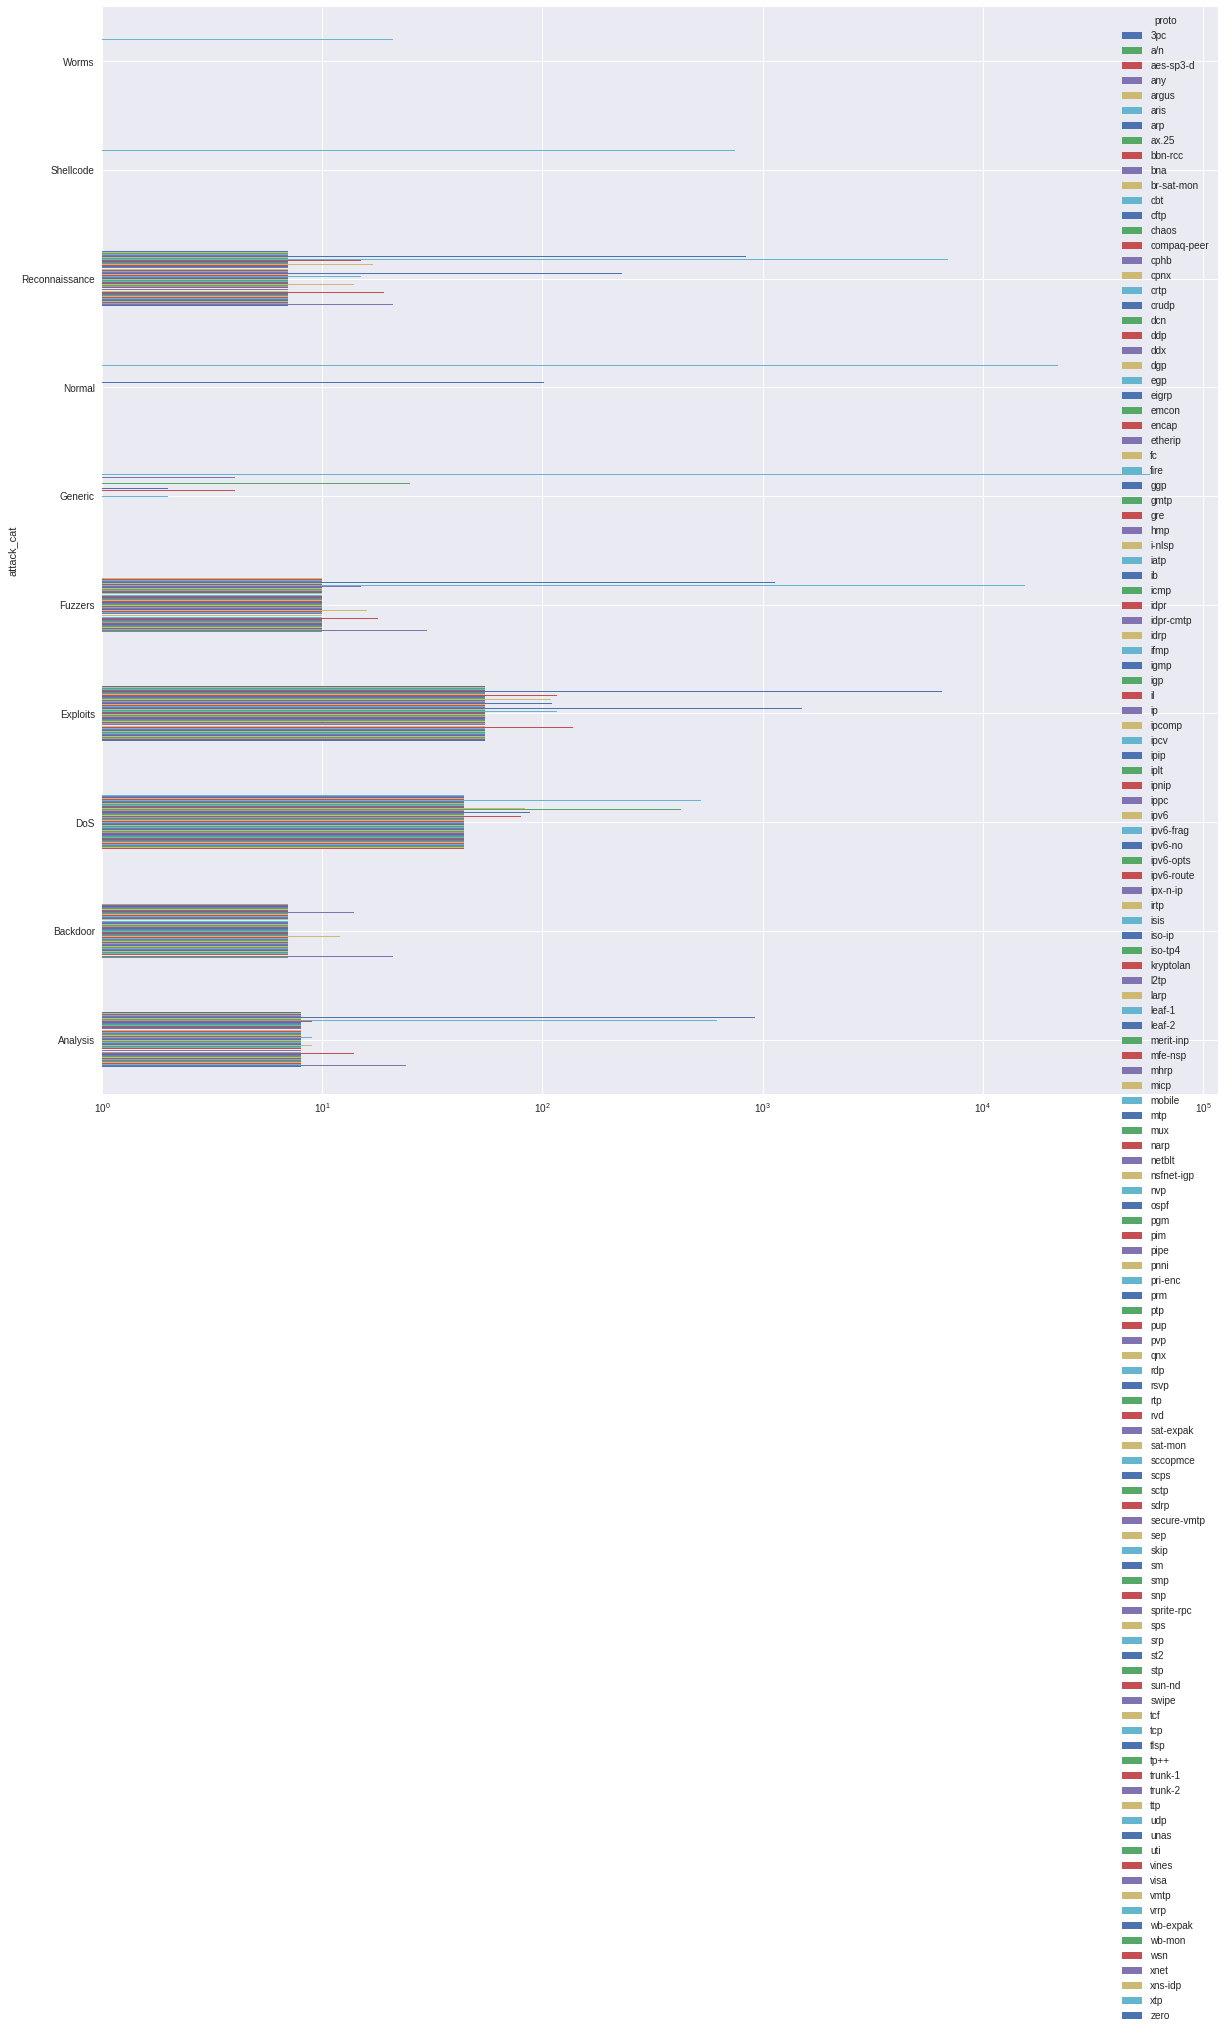

In [66]:
data.groupby('attack_cat').proto.value_counts().unstack().plot.barh(figsize=(20,20), log=True)

In [72]:
data[data.attack_cat == "Analysis"].proto.value_counts()

unas           926
tcp            622
ospf            75
sctp            26
any             24
rsvp            16
gre             14
swipe            9
ipv6             9
sun-nd           9
pim              9
mobile           9
sep              9
ib               8
fire             8
pgm              8
il               8
merit-inp        8
i-nlsp           8
prm              8
netblt           8
cphb             8
idpr-cmtp        8
pipe             8
qnx              8
micp             8
rvd              8
ipnip            8
eigrp            8
wb-expak         8
              ... 
pvp              8
narp             8
nsfnet-igp       8
ipip             8
srp              8
isis             8
uti              8
ddp              8
vines            8
compaq-peer      8
idrp             8
br-sat-mon       8
mfe-nsp          8
idpr             8
ipv6-route       8
sdrp             8
cftp             8
hmp              8
igp              8
argus            8
ipv6-opts        8
vmtp        

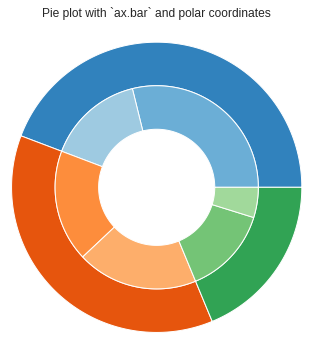

In [67]:
fig, ax = plt.subplots(subplot_kw=dict(polar=True))

size = 0.3
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])
#normalize vals to 2 pi
valsnorm = vals/np.sum(vals)*2*np.pi
#obtain the ordinates of the bar edges
valsleft = np.cumsum(np.append(0, valsnorm.flatten()[:-1])).reshape(vals.shape)

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))

ax.bar(x=valsleft[:, 0],
       width=valsnorm.sum(axis=1), bottom=1-size, height=size,
       color=outer_colors, edgecolor='w', linewidth=1, align="edge")

ax.bar(x=valsleft.flatten(),
       width=valsnorm.flatten(), bottom=1-2*size, height=size,
       color=inner_colors, edgecolor='w', linewidth=1, align="edge")

ax.set(title="Pie plot with `ax.bar` and polar coordinates")
ax.set_axis_off()
plt.show()

In [50]:
valsnorm

array([[1.8124573 , 0.96664389],
       [1.117682  , 1.20830487],
       [0.87602103, 0.30207622]])

In [49]:
valsleft

array([[0.        , 1.8124573 ],
       [2.77910119, 3.8967832 ],
       [5.10508806, 5.98110909]])

In [47]:
vals.flatten()

array([60., 32., 37., 40., 29., 10.])

# Missing Values:

   <ul>
        <li>
        Check for missing values.
        </li>
         <li>
        Replace those missing values.
        </li>
    </ul>

In [73]:
print(data.isnull().sum())

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

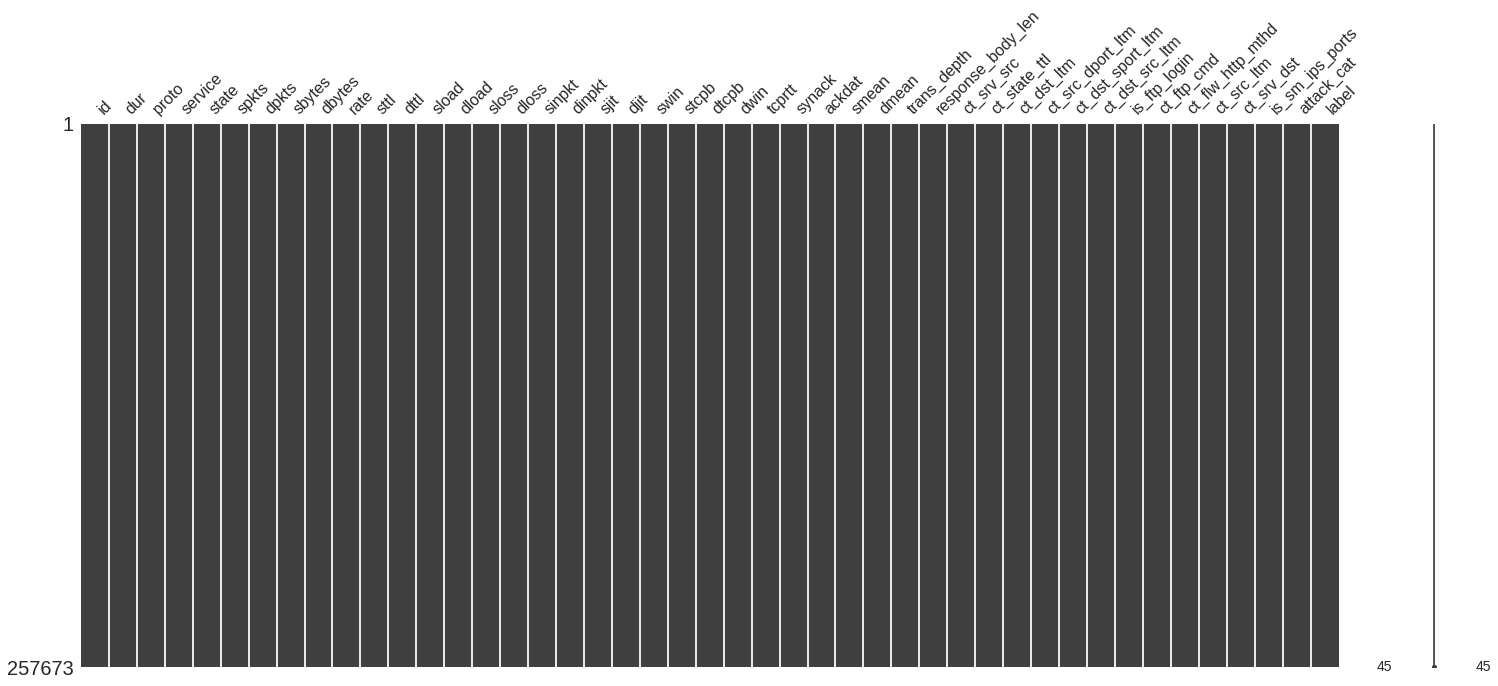

In [74]:
missingno.matrix(data)

Data is clean and there are no missing values. 

# Insights and steps: 
   <ul>
        <li>
        Data is clean.
        </li>
         <li>
        Data still needs furthur processing in terms of One-hot-encoding for categorical data.
                     E.g.: 'service' consists of different types, we have ftp, http, and '-' denoting (not available or None), So we will need to treat it as a missing value as we will change it from '-' to 'None' instead of dropping the whole column.
        </li>
            <li>
        Removing unnecessary features like 'id'.
        </li>
    </ul>

In [75]:
data['proto'].unique() #This is definitely a categorical feature.

array(['tcp', 'udp', 'arp', 'ospf', 'icmp', 'igmp', 'rtp', 'ddp',
       'ipv6-frag', 'cftp', 'wsn', 'pvp', 'wb-expak', 'mtp', 'pri-enc',
       'sat-mon', 'cphb', 'sun-nd', 'iso-ip', 'xtp', 'il', 'unas',
       'mfe-nsp', '3pc', 'ipv6-route', 'idrp', 'bna', 'swipe',
       'kryptolan', 'cpnx', 'rsvp', 'wb-mon', 'vmtp', 'ib', 'dgp',
       'eigrp', 'ax.25', 'gmtp', 'pnni', 'sep', 'pgm', 'idpr-cmtp',
       'zero', 'rvd', 'mobile', 'narp', 'fc', 'pipe', 'ipcomp', 'ipv6-no',
       'sat-expak', 'ipv6-opts', 'snp', 'ipcv', 'br-sat-mon', 'ttp',
       'tcf', 'nsfnet-igp', 'sprite-rpc', 'aes-sp3-d', 'sccopmce', 'sctp',
       'qnx', 'scps', 'etherip', 'aris', 'pim', 'compaq-peer', 'vrrp',
       'iatp', 'stp', 'l2tp', 'srp', 'sm', 'isis', 'smp', 'fire', 'ptp',
       'crtp', 'sps', 'merit-inp', 'idpr', 'skip', 'any', 'larp', 'ipip',
       'micp', 'encap', 'ifmp', 'tp++', 'a/n', 'ipv6', 'i-nlsp',
       'ipx-n-ip', 'sdrp', 'tlsp', 'gre', 'mhrp', 'ddx', 'ippc', 'visa',
       'secure-vmtp', 

In [76]:
data['service'].unique() #Here, we'll deal with the type of service that is '-'
data['service']= np.where(data['service'] == '-', 'None', data['service'])
print(data['service'].unique())

['None' 'ftp' 'smtp' 'snmp' 'http' 'ftp-data' 'dns' 'ssh' 'radius' 'pop3'
 'dhcp' 'ssl' 'irc']


In [77]:
data['state'].unique() #Keep it.

array(['FIN', 'INT', 'CON', 'ECO', 'REQ', 'RST', 'PAR', 'URN', 'no',
       'ACC', 'CLO'], dtype=object)

##### Now, let's try to automate this process.

In [80]:
def Remove_dump_values(data, cols):
    for col in cols:
        data[col] = np.where(data[col] == '-', 'None', data[col])
    return data

In [81]:
cols = data.columns
data_bin = Remove_dump_values(data, cols)

**Removing unnecessary features:**

In [82]:
data_bin = data_bin.drop(['id'], axis=1) #Remove Unnecessary features

##### Categorical Features:
One Hot Encoding using cols_cat

In [83]:
data_bin.drop(['attack_cat'], axis=1, inplace=True)

In [84]:
cols_cat = cols_cat.drop(['attack_cat'])

In [85]:
cols_cat

Index(['proto', 'service', 'state'], dtype='object')

**Do one-hot encoding**

In [86]:
data_bin_hot = pd.get_dummies(data_bin,columns=cols_cat)

In [87]:
data_bin_hot.shape

(257673, 197)

##### Normalization:
Normalize all the values in the dataset.


In [88]:
cols_numeric = list(cols_numeric)
cols_numeric.remove('label')
cols_numeric.remove('id')

In [89]:
data_bin_hot[cols_numeric] = data_bin_hot[cols_numeric].astype('float') 

In [22]:
data_bin_hot[cols_numeric] = (data_bin_hot[cols_numeric] - np.min(data_bin_hot[cols_numeric])) / np.std(data_bin_hot[cols_numeric])

In [23]:
data_bin_hot.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,state_CLO,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,1.841222e-06,0.007356,0.0,0.002716,0.0,0.566962,2.478337,0.0,0.971102,0.0,...,0,0,0,0,1,0,0,0,0,0
1,1.339070e-06,0.007356,0.0,0.010002,0.0,0.779572,2.478337,0.0,4.743422,0.0,...,0,0,0,0,1,0,0,0,0,0
2,8.369190e-07,0.007356,0.0,0.006008,0.0,1.247316,2.478337,0.0,4.600204,0.0,...,0,0,0,0,1,0,0,0,0,0
3,1.004303e-06,0.007356,0.0,0.005041,0.0,1.039430,2.478337,0.0,3.230480,0.0,...,0,0,0,0,1,0,0,0,0,0
4,1.673838e-06,0.007356,0.0,0.012096,0.0,0.623658,2.478337,0.0,4.578667,0.0,...,0,0,0,0,1,0,0,0,0,0


# Train and Test set splitting:


We won't split the Data.. We do care about precision in our case!

In [24]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)

In [25]:
from sklearn import model_selection
from sklearn import metrics
X = data_bin_hot.drop('label', axis=1)
Y = data_bin_hot['label']

In [26]:
global X #To include in upcoming functions.

# Machine Learning Models:
<ul>
    <li>
        This is a Classification problem where we want to detect whether there is an attack or not.
    </li>
    <li>
        We will use simple Logistic Regression.
    </li>
        <li>
            K-Nearest Neighbour (Lazy Algorithm)
    </li>
        <li>
        Decision Trees
    </li>
        <li>
        Random Forest (gini)
    </li>
        <li>
        Random Forest (Entropy or Information-gain)
    </li>
    </ul>

In [27]:
def fit_algo(algo, x, y, cv):
    #Fit the model
    model = algo.fit(x, y)
    
    #Check its score
    acc = round(model.score(x, y) *100, 2)
    y_pred = model_selection.cross_val_predict(algo, x, y, cv=cv, n_jobs = -1)
    
    acc_cv = round(metrics.accuracy_score(Y,y_pred)*100, 2)
    
    return y_pred, acc, acc_cv, model

# Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
start_time = time.time()
pred_now, acc_lr, acc_cv_lr, lr = fit_algo(LogisticRegression(C=0.1)
                                        , X, Y, 10)

lr_time = (time.time() - start_time)

print("Accuracy: %s" % acc_lr)
print("Accuracy of CV: %s" % acc_cv_lr)
print("Execution time: %s" % lr_time)

Accuracy: 90.1
Accuracy of CV: 89.05
Execution time: 65.704843044281


# Feature Importance

In [29]:
def feature_plot(imp):
    global X
    fimp = pd.DataFrame({'Feature': X.columns, 'Importance' : np.round(imp)})
    fimp =fimp.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10,10))
    plt.plot(fimp['Feature'], fimp['Importance'])
    plt.xticks(rotation=90);

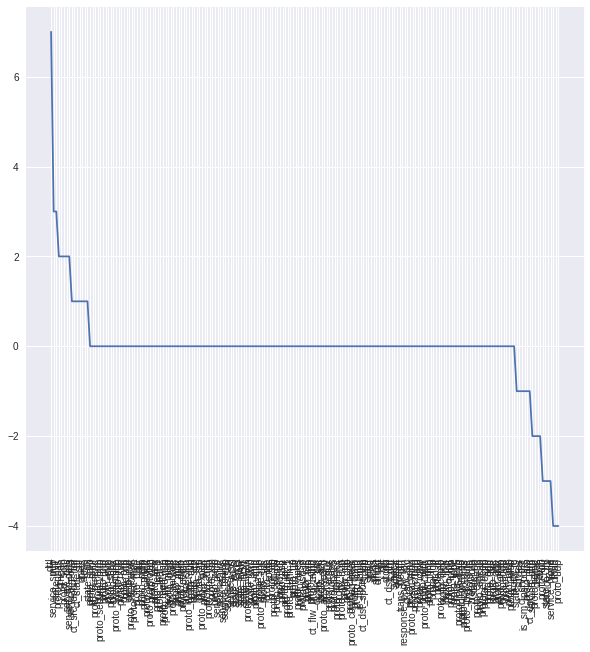

In [30]:
feature_plot(lr.coef_[0])

In [31]:
fimp_lr = pd.DataFrame({'Feature': X.columns, 'Importance' : np.round(lr.coef_[0])})
fimp_lr =fimp_lr.sort_values(by='Importance', ascending=False)
fimp_lr

,Feature,Importance
7,dttl,7.0
181,service_smtp,3.0
190,state_INT,3.0
159,proto_unas,2.0
24,dmean,2.0
...,...,...
175,service_ftp,-3.0
172,service_None,-3.0
16,swin,-4.0
9,dload,-4.0


In [32]:
#from sklearn.neighbors import KNeighborsClassifier
#start_time = time.time()
#pred_now, acc_knn, acc_cv_knn, knn = fit_algo(KNeighborsClassifier(n_neighbors = 3)
 #                                       , X, Y, 10)
#knn_time = (time.time() - start_time)

#print("Accuracy: %s" % acc_knn)
#print("Accuracy of CV: %s" % acc_cv_knn)
#print("Execution time: %s" % knn_time)


# Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier
start_time = time.time()
pred_now, acc_dt, acc_cv_dt, dt = fit_algo(DecisionTreeClassifier(random_state = 1)
                                        , X, Y, 10)

dt_time = (time.time() - start_time)

print("Accuracy: %s" % acc_dt)
print("Accuracy of CV: %s" % acc_cv_dt)
print("Execution time: %s" % dt_time)

Accuracy: 99.74
Accuracy of CV: 91.44
Execution time: 44.68880605697632


# Random Forest (Gini)

In [34]:
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()
pred_now, acc_rf, acc_cv_rf, rf = fit_algo(RandomForestClassifier(n_estimators = 100)
                                        , X, Y, 10)

rf_time = (time.time() - start_time)

print("Accuracy: %s" % acc_rf)
print("Accuracy of CV: %s" % acc_cv_rf)
print("Execution time: %s" % rf_time)


Accuracy: 99.74
Accuracy of CV: 92.61
Execution time: 305.97157526016235


# Random Forest (Information Gain)

In [35]:
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()
pred_now, acc_rf2, acc_cv_rf2, rf2 = fit_algo(RandomForestClassifier(n_estimators = 100, criterion='entropy')
                                        , X, Y, 10)

rf2_time = (time.time() - start_time)

print("Accuracy: %s" % acc_rf2)
print("Accuracy of CV: %s" % acc_cv_rf2)
print("Execution time: %s" % rf2_time)

Accuracy: 99.74
Accuracy of CV: 92.62
Execution time: 349.12206292152405


# Neural Networks

In [36]:
from sklearn.neural_network import MLPClassifier

start_time = time.time()
pred_now, acc_nn, acc_cv_nn, nn = fit_algo(MLPClassifier(hidden_layer_sizes = (20,), activation='relu', solver='adam')
                                        , X, Y, 5)

nn_time = (time.time() - start_time)

print("Accuracy: %s" % acc_nn)
print("Accuracy of CV: %s" % acc_cv_nn)
print("Execution time: %s" % nn_time)

Accuracy: 93.61
Accuracy of CV: 91.07
Execution time: 582.0847535133362


# Gaussian Naive Bayes

In [37]:
from sklearn.naive_bayes import GaussianNB
start_time = time.time()

pred_now, acc_gnb, acc_cv_gnb, gnb= fit_algo(GaussianNB()
                                        ,X,Y,5)

gnb_time = (time.time() - start_time)

print("Accuracy: %s" % acc_gnb)
print("Accuracy of CV: %s" % acc_cv_gnb)
print("Execution time: %s" % gnb_time)

Accuracy: 50.5
Accuracy of CV: 50.46
Execution time: 9.811775922775269


# Gradient Boosting

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
start_time = time.time()

pred_now, acc_gbt, acc_cv_gbt, gbt= fit_algo(GradientBoostingClassifier()
                                        , X, Y, 10)

gbt_time = (time.time() - start_time)

print("Accuracy: %s" % acc_gbt)
print("Accuracy of CV: %s" % acc_cv_gbt)
print("Execution time: %s" % gbt_time)

Accuracy: 93.38
Accuracy of CV: 92.09
Execution time: 1075.2000770568848


# SVM

In [39]:
from sklearn.svm import LinearSVC
start_time = time.time()

pred_now, acc_svc, acc_cv_svc, svc= fit_algo(LinearSVC()
                                        ,X,Y,10)

svc_time = (time.time() - start_time)

print("Accuracy: %s" % acc_svc)
print("Accuracy of CV: %s" % acc_cv_svc)
print("Execution time: %s" % svc_time)

Accuracy: 90.28
Accuracy of CV: 89.13
Execution time: 390.852520942688


# Cross-Validation Accuracy Comparison:

In [40]:
algo_name = ['Log. Reg.', 'Decision Tree', 'RandomForest Gini', 'RandomForest IG', 'Neural Network', 'Gaussian NB', 'GBC', 'SVM']
acc_df = pd.DataFrame({'Algorithm' : algo_name, 'Accuracy %' : [acc_cv_lr, acc_cv_dt, acc_cv_rf, acc_cv_rf2, acc_cv_nn, acc_cv_gnb, acc_cv_gbt, acc_cv_svc] })
acc_df = acc_df.sort_values(by='Accuracy %', ascending = False)
acc_df = acc_df.reset_index(drop=True)
acc_df

,Algorithm,Accuracy %
0,RandomForest IG,92.62
1,RandomForest Gini,92.61
2,GBC,92.09
3,Decision Tree,91.44
4,Neural Network,91.07
5,SVM,89.13
6,Log. Reg.,89.05
7,Gaussian NB,50.46


In [41]:
fimp_rf = pd.DataFrame({'Feature' : X.columns, 'Importance' : (rf.feature_importances_).astype(float)})
fimp_rf = fimp_rf.sort_values(by='Importance', ascending=False)
fimp_rf

,Feature,Importance
6,sttl,8.458975e-02
28,ct_state_ttl,6.496836e-02
9,dload,4.910523e-02
3,sbytes,4.312498e-02
8,sload,4.110580e-02
...,...,...
138,proto_secure-vmtp,1.008954e-09
137,proto_sdrp,7.807893e-10
169,proto_xns-idp,6.029932e-10
87,proto_ipip,2.777143e-10


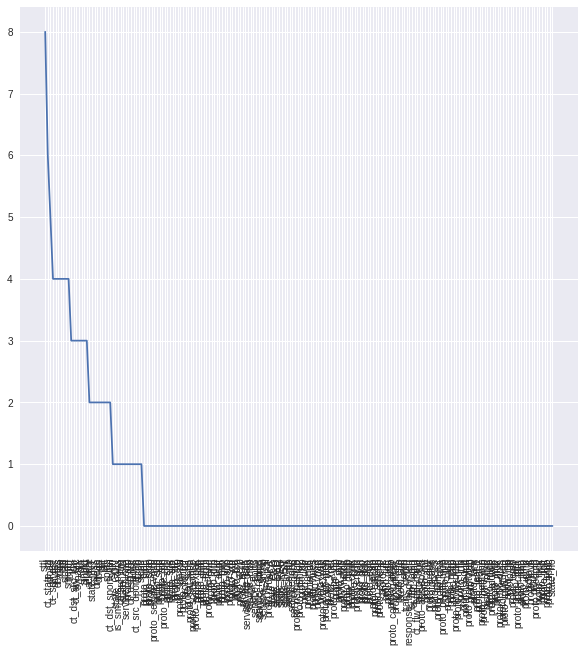

In [42]:
feature_plot(rf.feature_importances_*100)

# Save the best accuracy model

In [43]:
filename = 'RandomForest_IG_IDS.sav'
pickle.dump(rf2, open(filename, 'wb'))

# Loading the model (for future use)

In [44]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X, Y)
print(result)

0.9974347331695599
